In [1]:
%load_ext autoreload
%autoreload 2

In [17]:
from typing import Dict, Tuple

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer as PLTrainer
from torch import Tensor, nn
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy, F1Score, MetricCollection, Precision, Recall
from torchvision import transforms
from torchvision.datasets import MNIST

from energizer import AccumulatorStrategy, RandomStrategy, Trainer
from energizer.acquisition_functions import entropy, expected_entropy

In [8]:
# load and preprocess datasets
data_dir = "./data"
preprocessing_pipe = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ]
)
train_set = MNIST(data_dir, train=True, download=False, transform=preprocessing_pipe)
test_set = MNIST(data_dir, train=False, download=False, transform=preprocessing_pipe)
train_set, val_set = random_split(train_set, [55000, 5000])

# create dataloaders
batch_size = 32
eval_batch_size = 128  # this is use when evaluating on the pool too
train_dl = DataLoader(train_set, batch_size=batch_size)
val_dl = DataLoader(val_set, batch_size=eval_batch_size)
test_dl = DataLoader(test_set, batch_size=eval_batch_size)

In [9]:
class MNISTModel(LightningModule):
    def __init__(self) -> None:
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5),
            nn.Dropout2d(),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=5),
            nn.Dropout2d(),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1024, 128),
            nn.Dropout(),
            nn.Linear(128, 10),
        )
        for stage in ("train", "val", "test"):
            setattr(self, f"{stage}_accuracy", Accuracy())

    def forward(self, x: Tensor) -> Tensor:
        return self.model(x)

    def loss(self, logits: Tensor, targets: Tensor) -> Tensor:
        return F.cross_entropy(logits, targets)

    def step(self, batch: Tuple[Tensor, Tensor], stage: str) -> Dict[str, Tensor]:
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)
        accuracy = getattr(self, f"{stage}_accuracy")(logits, y)
        self.log(f"{stage}/loss", loss, on_epoch=True, on_step=True, prog_bar=True)
        self.log(f"{stage}/accuracy", accuracy, on_epoch=True, on_step=True, prog_bar=True)
        return {"loss": loss, "logits": logits}

    def training_step(self, batch: Tuple[Tensor, Tensor], batch_idx: int) -> Dict[str, Tensor]:
        return self.step(batch, "train")

    def validation_step(self, batch: Tuple[Tensor, Tensor], batch_idx: int) -> Dict[str, Tensor]:
        return self.step(batch, "val")

    def test_step(self, batch: Tuple[Tensor, Tensor], batch_idx: int) -> Dict[str, Tensor]:
        return self.step(batch, "test")

    def configure_optimizers(self) -> None:
        return torch.optim.SGD(self.parameters(), lr=0.01)

In [10]:
class EntropyStrategy(AccumulatorStrategy):
    """A implememntation of the `Entropy` active learning strategy."""

    def pool_step(self, batch: Tuple[Tensor, Tensor], batch_idx: int) -> Tensor:
        # define how to perform the forward pass
        x, _ = batch
        logits = self(x)
        # use an acquisition/scoring function
        scores = entropy(logits)
        return scores

In [11]:
model = MNISTModel()
entropy_strategy = EntropyStrategy(model)
random_strategy = RandomStrategy(model)

x, _ = next(iter(train_dl))
model(x).shape, entropy_strategy(x).shape, random_strategy(x).shape

(torch.Size([32, 10]), torch.Size([32, 10]), torch.Size([32, 10]))

## Active fit

### Random strategy

In [38]:
model = MNISTModel()
random_strategy = RandomStrategy(model)


trainer = Trainer(
    query_size=10,
    max_epochs=3,
    max_labelling_epochs=3,
    # total_budget=5,
    test_after_labelling=True,
    # for testing purposes
    # limit_train_batches=10,
    # limit_val_batches=10,
    # limit_test_batches=10,
    # limit_pool_batches=10,
    # log_every_n_steps=1,
)

results = trainer.active_fit(
    model=random_strategy,
    train_dataloaders=train_dl,
    val_dataloaders=val_dl,
    test_dataloaders=test_dl,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | model          | Sequential | 184 K 
1 | train_accuracy | Accuracy   | 0     
2 | val_accuracy   | Accuracy   | 0     
3 | test_accuracy  | Accuracy   | 0     
----------------------------------------------
184 K     Trainable params
0         Non-trainable params
184 K     Total params
0.738     Total estimated model params size (MB)


Using `RandomStrategy`
Using underlying `MNISTModel`


-------------------------Labelling Iteration 0--------------------------
Testing DataLoader 0: 100%|██████████| 79/79 [00:04<00:00, 18.59it/s]

Using `RandomStrategy`

Pool loop: queried 10 instances randomly

Using underlying `MNISTModel`
MNISTModel state dict has been re-initialized



-------------------------Labelling Iteration 1--------------------------
Epoch 2: 100%|██████████| 41/41 [00:02<00:00, 18.10it/s, loss=2.26, v_num=9, test/loss_step=2.290, test/accuracy_step=0.188, test/loss_epoch=2.320, test/accuracy_epoch=0.0598, train/loss_step=2.170, train/accuracy_step=0.100, val/loss_step=2.280, val/accuracy_step=0.250, val/loss_epoch=2.320, val/accuracy_epoch=0.126, train/loss_epoch=2.170, train/accuracy_epoch=0.100] 

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 41/41 [00:02<00:00, 18.05it/s, loss=2.26, v_num=9, test/loss_step=2.290, test/accuracy_step=0.188, test/loss_epoch=2.320, test/accuracy_epoch=0.0598, train/loss_step=2.170, train/accuracy_step=0.100, val/loss_step=2.280, val/accuracy_step=0.250, val/loss_epoch=2.320, val/accuracy_epoch=0.126, train/loss_epoch=2.170, train/accuracy_epoch=0.100]

Using underlying `MNISTModel`



Testing DataLoader 0:  29%|██▉       | 23/79 [00:01<00:03, 18.64it/s]

/Users/pietrolesci/miniconda3/envs/energizer-dev/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [36]:
r = [
    (l.data_stats["train_size"], l.test_outputs[0]["test/accuracy_epoch"] if len(l.test_outputs) > 0 else 0.0)
    for l in results
]
train_size, accuracy = zip(*r)

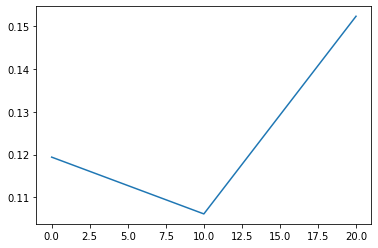

In [37]:
plt.plot(train_size, accuracy);

### Entropy strategy

In [ ]:
trainer = Trainer(
    query_size=2,
    max_epochs=10,
    max_labelling_epochs=4,
    # total_budget=5,
    log_every_n_steps=1,
    test_after_labelling=True,
    # for testing purposes
    limit_train_batches=10,
    limit_val_batches=10,
    limit_test_batches=10,
    limit_pool_batches=10,
)

trainer.active_fit(
    model=entropy_strategy,
    train_dataloaders=train_dl,
    val_dataloaders=val_dl,
    test_dataloaders=test_dl,
)

trainer.datamodule.stats

### Fit Logging

In [ ]:
model = MNISTModel()

trainer = Trainer(
    query_size=2,
    max_epochs=3,
    max_labelling_epochs=4,
    total_budget=5,
    log_every_n_steps=1,
    test_after_labelling=True,
    # for testing purposes
    limit_train_batches=10,
    limit_val_batches=10,
    limit_test_batches=10,
    limit_pool_batches=10,
)

trainer.fit(
    model=model,
    train_dataloaders=train_dl,
    val_dataloaders=val_dl,
)

In [ ]:
model = MNISTModel()

trainer = Trainer(
    query_size=2,
    max_epochs=3,
    max_labelling_epochs=4,
    total_budget=5,
    log_every_n_steps=1,
    test_after_labelling=True,
    # for testing purposes
    limit_train_batches=10,
    limit_val_batches=10,
    limit_test_batches=10,
    limit_pool_batches=10,
)

trainer.test(
    model=model,
    dataloaders=test_dl,
)

In [ ]:
model = MNISTModel()

pl_trainer = PLTrainer(
    max_epochs=3,
    log_every_n_steps=1,
    # for testing purposes
    limit_train_batches=10,
    limit_val_batches=10,
    limit_test_batches=10,
)

results = pl_trainer.test(
    model=model,
    dataloaders=test_dl,
)

In [32]:
"c".center(3, "-")

'-c-'

In [ ]:
trainer.validate(
    model=random_strategy.model,
    dataloaders=test_dl,
)